# Problem 4: Weak key schedule for DES
## Problem
- Alice made a mistake in her DES implementation: inside the function F in addition of data with a round secret subkey, she forgot to change the index. So, in her implementation, in each round, the data is XORed with the first round key.
- Alice used this DES implementation to encrypt `Book.txt` to `Book_cipher.txt`. We have to find the secret encryption key and decrypt a message encrypted by this implementation with the same key.


## Solution: 
- Alice's mistake means that in her implementation, the first round key is used for all rounds in DES. This makes the cryptosystem vulnerable to a slide attack. Reference: https://link.springer.com/content/pdf/10.1007/3-540-48519-8_18.pdf.
- With this kind of attack, we have to find a "slid pair" $(P, C)$ and $(P', C')$ first. $(P, C)$ form a slid pair with $(P', C')$ if $F(P) = P'$ and $F(C) = C'$. But we know that the round function $F((l, r)) = (r \oplus  f(l), l)$ modifies only half of its input. Therefore, the condition $F(x) = x'$ can be recognize that by simply comparing the left half of $x$ against the right half of $x'$. 
- Another problem that we have to mention, in the paper, it presents the slid attack in Feistel cipher, which do not have the "INITIAL PERMUTATION" before enter F function and the "INVERSE INITIAL PERMUTATION" after all rounds. It also changes the position of the $L$ block and $R$ block after all rounds. We can see that in two figures here.

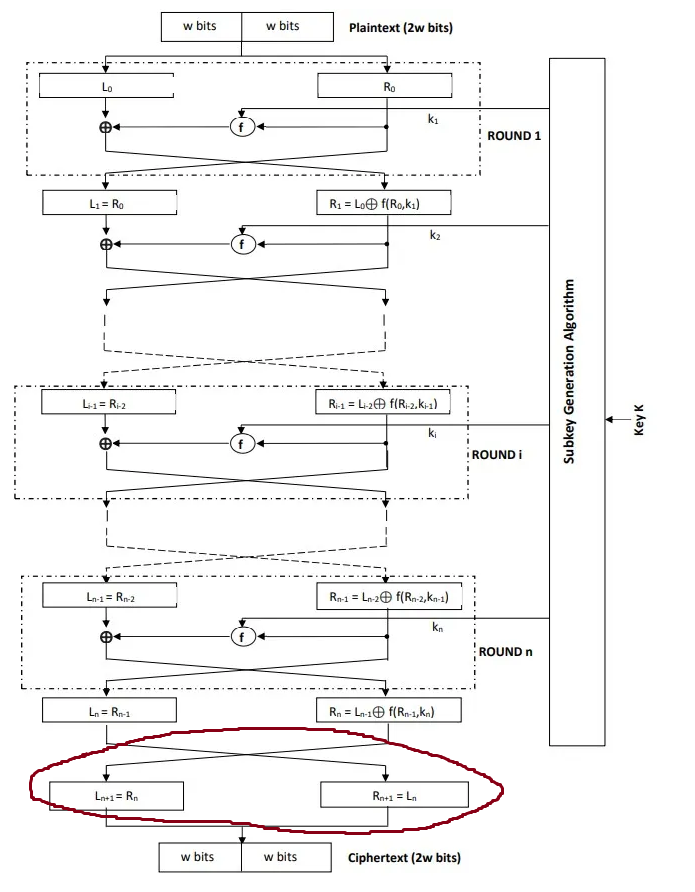
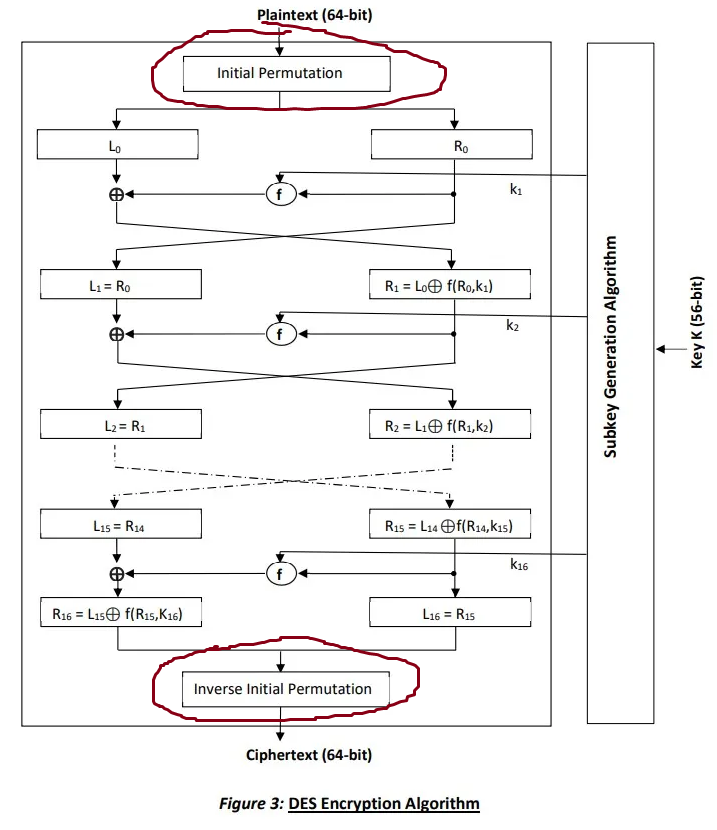

- After checking the slid pair condition, we have to synchronize the input and output from the DES cipher to the Feistel cipher
- To implement DES and some function for slide attack, I have referenced code from this: 
	- https://github.com/C4T-BuT-S4D/goldctf-2024/blob/master/sploits/digger/slide.py: contains function `extract_round_key_candidates` to extract round key from found slid pair, `bruteforce_master_key` to bruteforce all master keys with given round key. 
	- https://github.com/C4T-BuT-S4D/goldctf-2024/blob/master/sploits/digger/tables.py: Some necessary tables for DES implementation.
	- https://github.com/C4T-BuT-S4D/goldctf-2024/blob/master/sploits/digger/des.py: Correct DES implementation.

In [5]:
from tqdm import trange
import slide
import tables
import des
pt = open("Book.txt", "rb").read()
ct = open("Book_cipher.txt", "rb").read()

pt_block = [slide.permutate_bytes(pt[8 * i: 8 * (i + 1)], tables.INITIAL_PERMUTATION) for i in range(len(pt) // 8)]
ct_block = [slide.permutate_bytes(ct[8 * i: 8 * (i + 1)], tables.INITIAL_PERMUTATION) for i in range(len(ct) // 8)]
ct_block = [ct[4:] + ct[:4] for ct in ct_block]

pair = [(p, c) for p, c in zip(pt_block, ct_block)]

In [ ]:
def check_condition(x, x_):
	assert len(x) == len(x_)
	n = len(x)
	return x[:n // 2] == x_[n // 2:]

for i in trange(len(pair)):
	pt, ct = pair[i]
	for j in range(len(pair)):
		pt_, ct_ = pair[j]

		if check_condition(pt, pt_) and check_condition(ct, ct_):
			print(i, j)

Here is the output when running by pypy3:

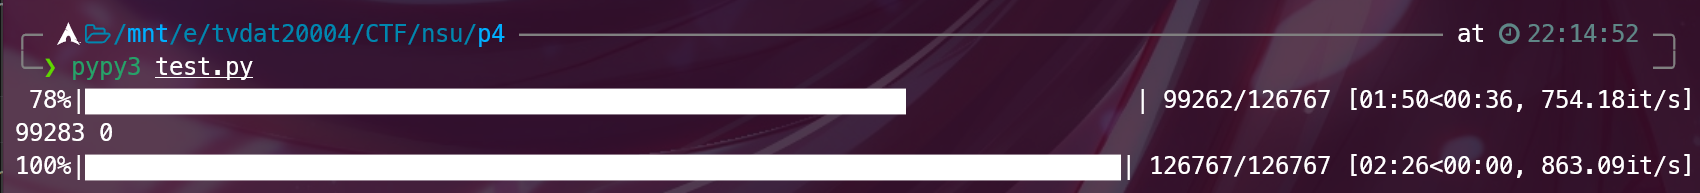


So we found the indexes of slid pair. Now we can easily find round key with `extract_round_key_candidates` function.

In [6]:
pt_block = [pt[i:i+8] for i in range(0, len(pt), 8)]
ct_block = [ct[i:i+8] for i in range(0, len(ct), 8)]

pt1 = pt_block[0] 
ct1 = ct_block[0]
pt2 = pt_block[99283]
ct2 = ct_block[99283]
pt2 = slide.permutate_bytes(pt2, tables.INITIAL_PERMUTATION)

candidates = slide.extract_round_key_candidates(pt1, pt2)
print(candidates)

[[[0, 0, 0, 0, 1, 1], [0, 0, 1, 0, 1, 0], [1, 0, 0, 0, 0, 1], [1, 1, 0, 0, 0, 0]], [[0, 0, 0, 1, 1, 1], [0, 0, 1, 1, 1, 0], [1, 0, 0, 0, 1, 1], [1, 1, 1, 1, 0, 0]], [[0, 1, 0, 0, 0, 0], [0, 1, 0, 0, 1, 1], [1, 1, 0, 0, 0, 1], [1, 1, 1, 1, 0, 0]], [[0, 0, 0, 1, 0, 1], [0, 0, 1, 0, 0, 0], [1, 0, 1, 0, 1, 1], [1, 1, 1, 0, 1, 0]], [[0, 0, 0, 1, 1, 1], [0, 1, 1, 0, 1, 0], [1, 0, 1, 0, 0, 1], [1, 1, 1, 0, 0, 0]], [[0, 1, 0, 0, 1, 1], [0, 1, 1, 1, 0, 0], [1, 0, 0, 1, 1, 0], [1, 1, 0, 1, 1, 1]], [[0, 1, 0, 0, 0, 0], [0, 1, 1, 1, 0, 1], [1, 1, 0, 0, 1, 0], [1, 1, 1, 0, 1, 1]], [[0, 0, 0, 1, 0, 0], [0, 1, 1, 1, 1, 1], [1, 0, 1, 0, 1, 0], [1, 1, 0, 1, 1, 1]]]


It produces a list of all possible round key, we can check if it is the round key we want.

In [7]:
import itertools
static_des = des.DES(b'AAAAAAAA')
for candidate in itertools.product(*candidates):
	candidate = sum(candidate, [])
	# change all round keys of static_des to candidate to make a faulty DES
	static_des.round_keys = [candidate] * len(static_des.round_keys)
	# check if the faulty DES encrypts pt1 to ct1
	if static_des.encrypt(pt1) == ct1:
		round_key = candidate
		break 
print(round_key)

[0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0]


Once `round_key` is found, we can easily find all possible key, base on how this [function](https://github.com/C4T-BuT-S4D/goldctf-2024/blob/2c3d8527fbbd8e870fbc02d895052789cdf0d7fb/sploits/digger/slide.py#L215) do.

In [12]:
master_keys = slide.bruteforce_master_key(round_key)
possible_key = []
for master_key in master_keys:
	indices = [i for i in range(len(master_key)) if master_key[i] < 0]
	for i in range(2 ** 8):
		key_part = des.int_to_bits(i, 8)
		candidate = list(master_key)
		for i, index in enumerate(indices):
			candidate[index] = key_part[i]
		key = des.bits_to_block(candidate, 8)
		cipher = des.DES(key)
		if cipher.round_keys[0] == round_key:
			possible_key.append(key)
# print(possible_key)
print(len(possible_key))

65536


In [14]:
ct = bytes.fromhex("86991641D28259604412D6BA88A5C0A6471CA7222C52482BF2D0E841D4343DFB877DC8E0147F3D5F20FC18FF28CB5C4DA8A0F4694861AB5E98F37ADBC2D69B35779D9001BB4B648518FE6EBC00B2AB10")
ct_block = [ct[8 * i: 8 * (i + 1)] for i in range(len(ct) // 8)]
pt = b""
cipher = des.DES(possible_key[0])
cipher.reversed_round_keys = [cipher.round_keys[0]] * len(cipher.round_keys)
for ct in ct_block:
	pt += cipher.decrypt(ct)
print(pt)

b'It is better to be in chains with friends, than to be in a garden with strangers'


Finally, the secret message is "It is better to be in chains with friends, than to be in a garden with strangers", and there are 65536 possible key stored in `possible_key` variables.